In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
prior_alpha = 1.
prior_beta  = 5.
latent_dim  = 50
epochs      = 500
batch_size  = 100

In [3]:
class KumarSampling(layers.Layer):
    #uses values a and b to compute latent variables
    def call(self, inputs):
        # compute v
        a, b = inputs
#         batch = tf.shape(a)[0]
        batch = batch_size
        u = tf.random.uniform(shape=(batch, latent_dim-1), minval=0.01, maxval=0.99)
        v = (1-(u**(1/b)))**(1/a)
#         print(v.shape)
        
        # initialize variables
        stick_segment = tf.zeros([batch, ])
        remaining_stick = tf.ones([batch, ])
        
        # compute stick segments
        def compute_latent(initializer, v):
            stick_segment, remaining_stick = initializer
            v = tf.convert_to_tensor(v)
            stick_segment = v * remaining_stick
            remaining_stick *= (1-v)
            return (stick_segment, remaining_stick)
        
        stick_segments, remaining_sticks = tf.scan(fn=compute_latent,
                                                  elems=tf.unstack(v, axis=0),
                                                  initializer=(stick_segment, remaining_stick), 
                                                  parallel_iterations=1)
        
        
        latent_pi = tf.concat([tf.transpose(stick_segments), tf.reshape(remaining_sticks[-1], [batch, 1])], 1)
        return latent_pi
            

def beta(a, b):
    return tf.math.exp(tf.math.lgamma(a) + tf.math.lgamma(b) - tf.math.lgamma(a+b))
    
def kl_divergence_kumar(prior_alpha, prior_beta, a, b):
    # compute taylor expansion for E[log (1-v)] term
    kl = 1./(1+a*b) * beta(1./a, b)
    kl += 1./(2+a*b) * beta(2./a, b)
    kl += 1./(3+a*b) * beta(3./a, b)
    kl += 1./(4+a*b) * beta(4./a, b)
    kl += 1./(5+a*b) * beta(5./a, b)
    kl += 1./(6+a*b) * beta(6./a, b)
    kl += 1./(7+a*b) * beta(7./a, b)
    kl += 1./(8+a*b) * beta(8./a, b)
    kl += 1./(9+a*b) * beta(9./a, b)
    kl += 1./(10+a*b) * beta(10./a, b)
    kl *= (prior_beta-1)*b
    
    # use another taylor approx for Digamma function  
    psi_b_taylor_approx = tf.math.log(b) - 1./(2 * b) - 1./(12 * b**2)
    kl += (a-prior_alpha)/a * (-0.57721 - psi_b_taylor_approx - 1/b)
    
    # add normalization constants
    kl += tf.math.log(a*b) + tf.math.log(beta(prior_alpha, prior_beta))
    
    # final term           
    kl += -(b-1)/b
    return tf.reduce_sum(kl, 1)

In [4]:
initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(500, activation="relu", 
                 kernel_initializer=initializer, bias_initializer='zeros')(x)
a = layers.Dense(latent_dim-1, activation="softplus", name="a", 
                 kernel_initializer=initializer, bias_initializer='zeros')(x)
# a = layers.Dense(1, activation="softplus", name="a", 
#                  kernel_initializer=initializer, bias_initializer='zeros')(x)
b = layers.Dense(latent_dim-1, activation="softplus", name="b", 
                 kernel_initializer=initializer, bias_initializer='zeros')(x)
# b = layers.Dense(1, activation="softplus", name="b", 
#                  kernel_initializer=initializer, bias_initializer='zeros')(x)
z = KumarSampling()([a, b])
encoder = keras.Model(encoder_inputs, [a, b, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          392500      flatten[0][0]                    
__________________________________________________________________________________________________
a (Dense)                       (None, 49)           24549       dense[0][0]                      
____________________________________________________________________________________________

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(500, activation="relu", 
                  kernel_initializer=initializer, bias_initializer='zeros')(latent_inputs)
x = layers.Dense(28*28, activation="sigmoid", 
                  kernel_initializer=initializer, bias_initializer='zeros')(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               25500     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               392784    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 418,284
Trainable params: 418,284
Non-trainable params: 0
_________________________________________________________________


In [6]:
class SB_VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(SB_VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            a, b, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = kl_divergence_kumar(prior_alpha, prior_beta, a, b)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, inputs):
        a, b, z = encoder(inputs)
        reconstruction = decoder(z)
        return reconstruction

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

sb_vae = SB_VAE(encoder, decoder)
adam = tf.keras.optimizers.Adam(learning_rate=0.0003,
                                beta_1=0.95,
                                beta_2=0.999,
                                epsilon=1e-07)
sb_vae.compile(optimizer=adam)

my_callbacks = [keras.callbacks.EarlyStopping(monitor='reconstruction_loss',
                                             patience=20,
                                             restore_best_weights=True)]

sb_losses = sb_vae.fit(mnist_digits, epochs=epochs, batch_size=batch_size)#, callbacks=my_callbacks)

Epoch 1/500
700/700 [==============================] - 49s 71ms/step - loss: 257.9733 - reconstruction_loss: 253.4003 - kl_loss: 4.5730
Epoch 2/500
700/700 [==============================] - 49s 70ms/step - loss: 206.2542 - reconstruction_loss: 205.4114 - kl_loss: 0.8428
Epoch 3/500
700/700 [==============================] - 49s 70ms/step - loss: 202.2719 - reconstruction_loss: 200.3610 - kl_loss: 1.9109
Epoch 4/500
700/700 [==============================] - 49s 71ms/step - loss: 196.0464 - reconstruction_loss: 193.6310 - kl_loss: 2.4155
Epoch 5/500
700/700 [==============================] - 49s 71ms/step - loss: 193.6313 - reconstruction_loss: 191.1554 - kl_loss: 2.4759
Epoch 6/500
700/700 [==============================] - 49s 71ms/step - loss: 192.3738 - reconstruction_loss: 189.6129 - kl_loss: 2.7609
Epoch 7/500
700/700 [==============================] - 49s 71ms/step - loss: 186.6612 - reconstruction_loss: 182.9951 - kl_loss: 3.6660
Epoch 8/500
700/700 [===========================

700/700 [==============================] - 49s 70ms/step - loss: 121.6593 - reconstruction_loss: 106.8712 - kl_loss: 14.7881
Epoch 61/500
700/700 [==============================] - 49s 70ms/step - loss: 121.4117 - reconstruction_loss: 106.5619 - kl_loss: 14.8498
Epoch 62/500
700/700 [==============================] - 49s 70ms/step - loss: 121.1922 - reconstruction_loss: 106.2843 - kl_loss: 14.9079
Epoch 63/500
700/700 [==============================] - 49s 70ms/step - loss: 121.0029 - reconstruction_loss: 106.0327 - kl_loss: 14.9702
Epoch 64/500
700/700 [==============================] - 49s 70ms/step - loss: 120.7989 - reconstruction_loss: 105.7651 - kl_loss: 15.0338
Epoch 65/500
700/700 [==============================] - 49s 70ms/step - loss: 120.5635 - reconstruction_loss: 105.4850 - kl_loss: 15.0785
Epoch 66/500
700/700 [==============================] - 49s 70ms/step - loss: 120.2883 - reconstruction_loss: 105.1712 - kl_loss: 15.1171
Epoch 67/500
700/700 [=========================

700/700 [==============================] - 49s 70ms/step - loss: 113.6733 - reconstruction_loss: 96.7614 - kl_loss: 16.9119
Epoch 120/500
700/700 [==============================] - 49s 70ms/step - loss: 113.5991 - reconstruction_loss: 96.6732 - kl_loss: 16.9259
Epoch 121/500
700/700 [==============================] - 49s 70ms/step - loss: 113.5334 - reconstruction_loss: 96.5700 - kl_loss: 16.9634
Epoch 122/500
700/700 [==============================] - 49s 70ms/step - loss: 113.4522 - reconstruction_loss: 96.4753 - kl_loss: 16.9769
Epoch 123/500
700/700 [==============================] - 49s 70ms/step - loss: 113.4375 - reconstruction_loss: 96.4212 - kl_loss: 17.0163
Epoch 124/500
700/700 [==============================] - 49s 70ms/step - loss: 113.2695 - reconstruction_loss: 96.2588 - kl_loss: 17.0107
Epoch 125/500
700/700 [==============================] - 49s 70ms/step - loss: 113.2788 - reconstruction_loss: 96.2280 - kl_loss: 17.0509
Epoch 126/500
700/700 [=========================

700/700 [==============================] - 49s 70ms/step - loss: 110.7204 - reconstruction_loss: 92.8584 - kl_loss: 17.8620 0s - loss: 110.7153 - reconstruction_loss: 92.8519 - kl_
Epoch 179/500
700/700 [==============================] - 49s 70ms/step - loss: 110.6283 - reconstruction_loss: 92.7727 - kl_loss: 17.8555
Epoch 180/500
700/700 [==============================] - 49s 70ms/step - loss: 110.6527 - reconstruction_loss: 92.7830 - kl_loss: 17.8697
Epoch 181/500
700/700 [==============================] - 49s 70ms/step - loss: 110.6743 - reconstruction_loss: 92.7744 - kl_loss: 17.8999
Epoch 182/500
700/700 [==============================] - 50s 72ms/step - loss: 110.5946 - reconstruction_loss: 92.6886 - kl_loss: 17.9060
Epoch 183/500
700/700 [==============================] - 49s 70ms/step - loss: 110.5496 - reconstruction_loss: 92.6263 - kl_loss: 17.9233
Epoch 184/500
700/700 [==============================] - 49s 71ms/step - loss: 110.5319 - reconstruction_loss: 92.6129 - kl_loss:

700/700 [==============================] - 49s 70ms/step - loss: 109.0922 - reconstruction_loss: 90.5895 - kl_loss: 18.5027
Epoch 237/500
700/700 [==============================] - 49s 70ms/step - loss: 109.1029 - reconstruction_loss: 90.5888 - kl_loss: 18.5140
Epoch 238/500
700/700 [==============================] - 49s 70ms/step - loss: 109.0511 - reconstruction_loss: 90.5196 - kl_loss: 18.5315
Epoch 239/500
700/700 [==============================] - 49s 70ms/step - loss: 109.0293 - reconstruction_loss: 90.4949 - kl_loss: 18.5344
Epoch 240/500
700/700 [==============================] - 49s 70ms/step - loss: 109.0218 - reconstruction_loss: 90.4820 - kl_loss: 18.5398
Epoch 241/500
700/700 [==============================] - 49s 70ms/step - loss: 109.0221 - reconstruction_loss: 90.4692 - kl_loss: 18.5529
Epoch 242/500
700/700 [==============================] - 49s 70ms/step - loss: 109.0267 - reconstruction_loss: 90.4565 - kl_loss: 18.5703
Epoch 243/500
700/700 [=========================

700/700 [==============================] - 49s 70ms/step - loss: 107.9442 - reconstruction_loss: 88.9242 - kl_loss: 19.0199
Epoch 296/500
700/700 [==============================] - 50s 71ms/step - loss: 107.9125 - reconstruction_loss: 88.8893 - kl_loss: 19.0232
Epoch 297/500
700/700 [==============================] - 49s 71ms/step - loss: 107.8857 - reconstruction_loss: 88.8398 - kl_loss: 19.0459
Epoch 298/500
700/700 [==============================] - 49s 70ms/step - loss: 107.8620 - reconstruction_loss: 88.8240 - kl_loss: 19.0380
Epoch 299/500
700/700 [==============================] - 49s 70ms/step - loss: 107.8441 - reconstruction_loss: 88.7921 - kl_loss: 19.0519
Epoch 300/500
700/700 [==============================] - 49s 71ms/step - loss: 107.8481 - reconstruction_loss: 88.7908 - kl_loss: 19.0573
Epoch 301/500
700/700 [==============================] - 49s 70ms/step - loss: 107.8416 - reconstruction_loss: 88.7711 - kl_loss: 19.0705
Epoch 302/500
700/700 [=========================

700/700 [==============================] - 49s 70ms/step - loss: 107.0473 - reconstruction_loss: 87.6359 - kl_loss: 19.4114
Epoch 354/500
700/700 [==============================] - 49s 70ms/step - loss: 107.1004 - reconstruction_loss: 87.6728 - kl_loss: 19.4276
Epoch 355/500
700/700 [==============================] - 49s 70ms/step - loss: 107.0698 - reconstruction_loss: 87.6476 - kl_loss: 19.4222
Epoch 356/500
700/700 [==============================] - 49s 70ms/step - loss: 107.0464 - reconstruction_loss: 87.6125 - kl_loss: 19.4340
Epoch 357/500
700/700 [==============================] - 49s 70ms/step - loss: 107.0609 - reconstruction_loss: 87.6181 - kl_loss: 19.4428
Epoch 358/500
700/700 [==============================] - 49s 70ms/step - loss: 107.0230 - reconstruction_loss: 87.5776 - kl_loss: 19.4454
Epoch 359/500
700/700 [==============================] - 49s 70ms/step - loss: 106.9896 - reconstruction_loss: 87.5361 - kl_loss: 19.4536
Epoch 360/500
700/700 [=========================

700/700 [==============================] - 51s 72ms/step - loss: 106.3983 - reconstruction_loss: 86.6763 - kl_loss: 19.7220
Epoch 413/500
700/700 [==============================] - 51s 72ms/step - loss: 106.3554 - reconstruction_loss: 86.6318 - kl_loss: 19.7236
Epoch 414/500
700/700 [==============================] - 51s 73ms/step - loss: 106.3730 - reconstruction_loss: 86.6514 - kl_loss: 19.7216
Epoch 415/500
700/700 [==============================] - 51s 72ms/step - loss: 106.3544 - reconstruction_loss: 86.6295 - kl_loss: 19.7249
Epoch 416/500
700/700 [==============================] - 51s 72ms/step - loss: 106.3790 - reconstruction_loss: 86.6420 - kl_loss: 19.7371
Epoch 417/500
700/700 [==============================] - 51s 72ms/step - loss: 106.3308 - reconstruction_loss: 86.5924 - kl_loss: 19.7384
Epoch 418/500
700/700 [==============================] - 51s 72ms/step - loss: 106.3168 - reconstruction_loss: 86.5747 - kl_loss: 19.7421 0s - loss: 106.3290 - reconstruction_loss: 86.58

700/700 [==============================] - 52s 74ms/step - loss: 105.8020 - reconstruction_loss: 85.8415 - kl_loss: 19.9605
Epoch 471/500
700/700 [==============================] - 52s 74ms/step - loss: 105.8455 - reconstruction_loss: 85.8798 - kl_loss: 19.9657
Epoch 472/500
700/700 [==============================] - 52s 74ms/step - loss: 105.8067 - reconstruction_loss: 85.8311 - kl_loss: 19.9756
Epoch 473/500
700/700 [==============================] - 52s 75ms/step - loss: 105.7920 - reconstruction_loss: 85.8214 - kl_loss: 19.9706
Epoch 474/500
700/700 [==============================] - 52s 74ms/step - loss: 105.8312 - reconstruction_loss: 85.8498 - kl_loss: 19.9814
Epoch 475/500
700/700 [==============================] - 52s 75ms/step - loss: 105.7944 - reconstruction_loss: 85.8127 - kl_loss: 19.9817
Epoch 476/500
700/700 [==============================] - 52s 75ms/step - loss: 105.7883 - reconstruction_loss: 85.8024 - kl_loss: 19.9858
Epoch 477/500
700/700 [=========================

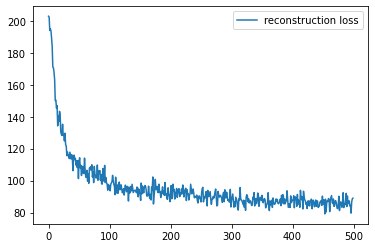

In [11]:
# plot loss function
plt.plot(sb_losses.history['reconstruction_loss'], label='reconstruction loss')
# plt.plot(sb_losses.history['kl_loss'], label='kl loss')
# plt.plot(sb_losses.history['loss'], label='total loss')
plt.legend()
plt.show()

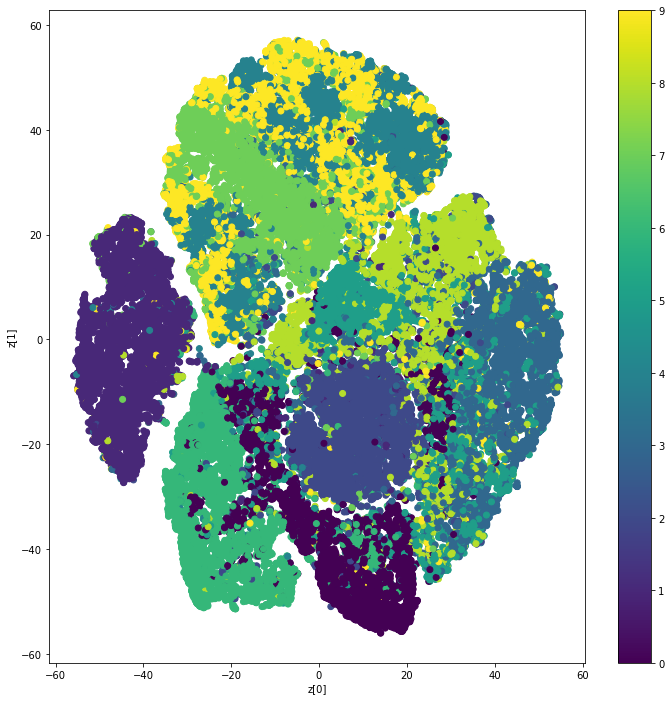

In [9]:
def plot_tsne_latent(encoder, data, labels):
    _, _, z = encoder.predict(data, batch_size=batch_size)
    z_mean_embedded = TSNE(n_components=2, verbose=0).fit_transform(z)
    plt.figure(figsize=(12, 12))
    plt.scatter(z_mean_embedded[:, 0], z_mean_embedded[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_tsne_latent(encoder, x_train, y_train)

Text(0.5, 1.0, 'reconstruction')

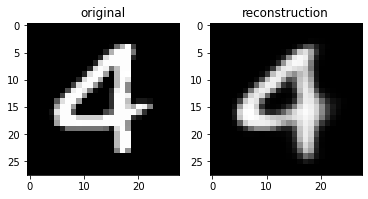

In [28]:
index = np.random.randint(0, mnist_digits.shape[0], size=batch_size)
prediction = sb_vae.predict(mnist_digits[index], batch_size=batch_size)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mnist_digits[index][0].reshape((28, 28)), cmap='gray')
ax1.set_title('original')
ax2.imshow(prediction[0].reshape((28, 28)), cmap='gray')
ax2.set_title('reconstruction')